In [4]:
import torch
import matplotlib.pyplot as plt
import torch.utils as utils

In [2]:
#IMPORT MNIST DIGIT DATASET
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = datasets.MNIST('data', train=True, download=True, transform=transform)
# split the data into training and validation datasets
seed_value = 42
generator = torch.Generator()
generator.manual_seed(seed_value)

training_data, validation_data = utils.data.random_split(data, [50000, 10000],generator=generator)

test_data = datasets.MNIST('data', train=False, download=True, transform=transform)

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

In [6]:
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = torch.nn.Sigmoid() ## using sigmoid activation function, because when we 
        ## are normalizing the pixel values to the range of -1 to 1 , we wouldn't want to lose the negative values
        self.conv1 = torch.nn.Conv2d(1, 32, 3,1)
        self.conv2 = torch.nn.Conv2d(32,64,3,1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.maxpool1 = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    
    def forward(self, x):
        x = self.activation(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)        
        return x


In [9]:
net = Net()

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [12]:
#TRAINING
num_epochs = 15
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, targets = data
        outputs = net(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward() # this is where the model learns by backpropagating
        optimizer.step() # this is where the model optimizes its weights
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == targets).sum().item() 
        train_total += targets.size()[0]
    print(f'Epoch {epoch + 1} training accuracy: {((train_correct/train_total*1.0)*100)}% training loss: {train_loss/len(train_loader):.5f}')
    scheduler.step()
    train_loss_history.append(train_loss/len(train_loader))   
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    net.eval()
    for inputs, labels in validation_loader:

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size()[0]
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {((val_correct/val_total*1.0)*100)}% validation loss: {val_loss/len(test_loader):.5f}')
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 91.648% training loss: 0.27869
Epoch 1 validation accuracy: 96.58% validation loss: 0.10471
Epoch 2 training accuracy: 96.842% training loss: 0.10416
Epoch 2 validation accuracy: 97.27% validation loss: 0.08524
Epoch 3 training accuracy: 97.47200000000001% training loss: 0.08294
Epoch 3 validation accuracy: 97.77% validation loss: 0.07064
Epoch 4 training accuracy: 97.622% training loss: 0.07556
Epoch 4 validation accuracy: 97.52% validation loss: 0.08282
Epoch 5 training accuracy: 97.77799999999999% training loss: 0.06893
Epoch 5 validation accuracy: 97.18% validation loss: 0.09863
Epoch 6 training accuracy: 98.828% training loss: 0.03846
Epoch 6 validation accuracy: 98.18% validation loss: 0.05802
Epoch 7 training accuracy: 99.074% training loss: 0.03069
Epoch 7 validation accuracy: 98.19% validation loss: 0.05931
Epoch 8 training accuracy: 99.076% training loss: 0.02906
Epoch 8 validation accuracy: 98.31% validation loss: 0.05831
Epoch 9 training accuracy:

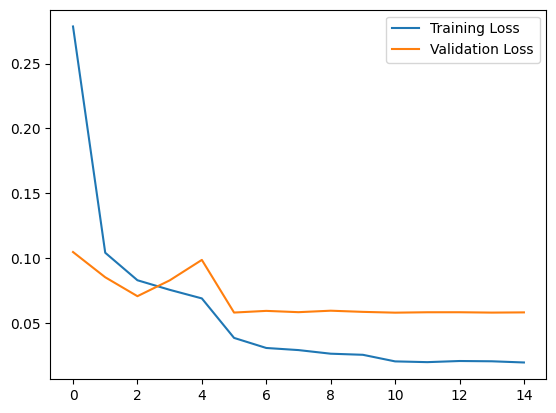

In [13]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()


In [14]:
test_loss = 0.0
test_correct = 0
test_total = 0
for inputs, labels in test_loader:

    outputs = net(inputs)
    loss = loss_fn(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()
    test_total += labels.size()[0]
    test_loss += loss.item()
print(f'Model Test accuracy: {((test_correct/test_total*1.0)*100)}% test loss: {test_loss/len(test_loader):.5f}')

Model Test accuracy: 98.15% test loss: 0.06955
